# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Nettoyage et analyse exploratoire des données

<img  width="76" height="30" src="https://olist.com/wp-custom/themes/olist20/assets/img/brand.svg" alt="Logo olist">


<!--TABLE OF CONTENTS-->

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
  - [1.4 Des routines statistiques](#1.4-Des-routines-statistiques)
- [2. Import et nettoyage des données](#2.-Import-et-nettoyage-des-données)
  - [2.1 Description des données (metadata)](<#2.1-Description-des-données-(metadata)>)
  - [2.2 Import des données](#2.2-Import-des-données)
  - [2.3 Description de données (après import)](<#2.3-Description-de-données-(après-import)>)
  - [2.4 Nettoyage des données](#2.4-Nettoyage-des-données)
- [3. Analyse Exploratoire](#3.-Analyse-Exploratoire)
  - [3.1 Données numériques](#3.1-Données-numériques)
  - [3.2 Données catégoriques](#3.2-Données-catégoriques)
  - [3.3 Associations entre variables catégoriques et numériques](#3.3-Associations-entre-variables-catégoriques-et-numériques)
- [4. Feature Engineering](#4.-Feature-Engineering)
  - [4.1 Nouvelles 'features' catégoriques](#4.1-Nouvelles-'features'-catégoriques)
  - [4.2 Nouvelles 'features' numériques](#4.2-Nouvelles-'features'-numériques)
- [5. Enregistrement des données nettoyées](#5.-Enregistrement-des-données-nettoyées)
  - [5.1 Sommaire des données nettoyées](#5.1-Sommaire-des-données-nettoyées)


# 1. Compréhension du problème

## 1.1 Mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


### Indicateurs pour segmenter les clients

#### Segmentation RFM

Pour établir des segments de clients homogènes, la [segmentation RFM](https://www.definitions-marketing.com/definition/segmentation-rfm/) prend en compte:

- la **Récence** (date de la dernière commande);
- la **Fréquence** des commandes; et
- le **Montant** (de la dernière commande ou sur une période donnée)

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.


#### Autres indicateurs possibles

On peut aussi segmenter les clients sur d'autres indicateurs :

- leur **satisfaction** sur les commandes
- la **catégorie de produits** qu'ils commande (est-ce qu'il y a certains catégories plus satisfaisant que d'autres?)
- la **rapidité de livraison** des commandes (est-ce que les clients qui habite près des vendeurs ont un comportement diffèrent que les clients plus loin de leur commande ?)
- les **vendeurs** qu'ils adoptent (est-ce qu'il y a un rélation entre clients étoiles et certains vendeurs?)


### Objectives d'analyse exploratoire

- Connaitre les données
- Nettoyer les données
- Identifier les indicateurs actionable
- Créer des nouvelles features / indicateurs si besoin


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'dython'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import missingno as msno
import sklearn
import dython
# pour calculer VIF -Variance Influence Factor
from sklearn.linear_model import LinearRegression
# correlations catégoriques (Cramers V, Theils U)
from dython.nominal import associations


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
json==2.0.9; numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; missingno==0.5.0; sklearn==1.0.2; dython==0.6.8


### 1.2.3 Configuration défauts d'affichage


In [5]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/notebook'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# 2. Import et nettoyage des données

Olist a fournit une [base de données](https://www.kaggle.com/olistbr/brazilian-ecommerce) anonymisée
comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de
satisfaction, et la localisation des clients depuis janvier 2017.


## 2.1 Description des données (metadata)

Le data schema et déscription des champs sont fournis à la même [adresse](https://www.kaggle.com/olistbr/brazilian-ecommerce) que les données:

<img width="564" height="339" alt="Data Schema" src="https://i.imgur.com/HRhd2Y0.png">


## 2.2 Import des données


In [9]:
DATA_DIR = 'data/raw'


def load_dataset(set_name='customers'):
    filename = f'{DATA_DIR}/olist_{set_name}_dataset.csv'
    df = pd.read_csv(filename)
    print(f'{set_name}.shape = {df.shape}; columns : {list(df.columns)}')
    return df


customers = load_dataset('customers')

customers.head()


customers.shape = (99441, 5); columns : ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


## Chargé les autres datasets


In [10]:
geolocation = load_dataset('geolocation')
order_items = load_dataset('order_items')
order_payments = load_dataset('order_payments')
order_reviews = load_dataset('order_reviews')
orders = load_dataset('orders')
products = load_dataset('products')
sellers = load_dataset('sellers')
product_category_names = pd.read_csv(
    'data/raw/product_category_name_translation.csv')


geolocation.shape = (1000163, 5); columns : ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
order_items.shape = (112650, 7); columns : ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
order_payments.shape = (103886, 5); columns : ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
order_reviews.shape = (99224, 7); columns : ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
orders.shape = (99441, 8); columns : ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
products.shape = (32951, 9); columns : ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_ph

## 2.3 Description de données (après import)


In [11]:
def decrire_dataframe(df: pd.DataFrame):
    """Retourner un dataframe avec des informations sur les colonnes d'un dataframe"""
    print(f'{df.shape[0]} registres')
    ret = df.columns.to_frame(name="column").set_index('column')
    ret['% manquantes'] = df.isna().mean()*100
    ret['unique'] = df.nunique()
    ret['dtype'] = df.dtypes
    ret['min'] = df.min()
    ret['max'] = df.max()
    ret['std'] = df.std()
    return ret


### Customers


In [12]:
decrire_dataframe(customers)


99441 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
customer_id,0.00,99441,object,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99,nan
customer_unique_id,0.00,96096,object,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb,nan
customer_zip_code_prefix,0.00,14994,int64,1003,99990,29797.94
customer_city,0.00,4119,object,abadia dos dourados,zortea,nan
customer_state,0.00,27,object,AC,TO,nan


#### Combien de clients ont plus d'un 'customer_id'?

Il y a 99441 registres, tous avec des unique customer_id (aucun dupliqué)
Il y a 96096 unique clients.


In [13]:
customers[['customer_id', 'customer_unique_id']].groupby(
    'customer_unique_id').agg('count').value_counts()


customer_id
1              93099
2               2745
3                203
4                 30
5                  8
6                  6
7                  3
17                 1
9                  1
dtype: int64

#### Qualité des données customer

- 100% remplis
- utilise 'customer_unique_id' pour identifier chaque client, car environ 3000 clients ont plusieurs 'customer_id'
- besoin de merge avec **geolocation** pour savoir la localisation des clients


### Geolocation


In [14]:
decrire_dataframe(geolocation)


1000163 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.00,19015,int64,1001,99990,30549.34
geolocation_lat,0.00,717358,float64,-36.61,45.07,5.72
geolocation_lng,0.00,717613,float64,-101.47,121.11,4.27
geolocation_city,0.00,8011,object,* cidade,óleo,nan
geolocation_state,0.00,27,object,AC,TO,nan


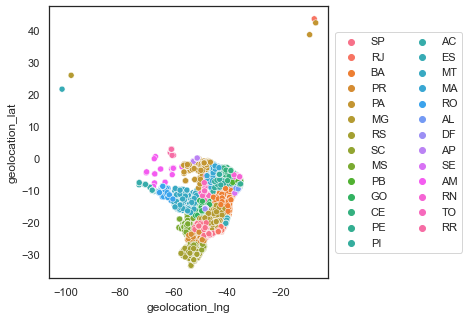

In [15]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=geolocation.sample(50000, random_state=0),
                x='geolocation_lng', y='geolocation_lat', hue='geolocation_state')
plt.legend(bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)


#### Geolocation : qualité des données

- les 'states' sont 100% remplies; il y a 27 unités fédératives au brésil
- les 'city' ne sont pas toujours des vraies villes
- les latitudes ne sont pas toujours en brésil ([5°16'20" Nord à 33°44'32" Sud de latitude](https://fr.wikipedia.org/wiki/G%C3%A9ographie_du_Br%C3%A9sil#Situation_et_%C3%A9tendue))
- les longitudes ne sont pas toujours en brésil ([34°47'30" Ouest à 73°59'32" Ouest de longitude](https://fr.wikipedia.org/wiki/G%C3%A9ographie_du_Br%C3%A9sil#Situation_et_%C3%A9tendue))
- Ce n'est pas clair pourquoi il y a environ 75 (lat,lng) pour chaque zip code - les (lat,lng) des adresses dans chaque zip ?


#### Geolocations hors brésil


In [16]:
print('trop au nord ', geolocation[geolocation['geolocation_lat'] > 5.3].shape)
print('trop au sud ',
      geolocation[geolocation['geolocation_lat'] < -33.75].shape)
print("trop à l'est",
      geolocation[geolocation['geolocation_lng'] > -34.7].shape)
print("trop à l'ouest",
      geolocation[geolocation['geolocation_lng'] < -74].shape)

mask_lat = (geolocation['geolocation_lat'] > 5.3) | (
    geolocation['geolocation_lat'] < -33.75)
mask_lng = (geolocation['geolocation_lng'] > -
            34.7) | (geolocation['geolocation_lng'] < -74)
hors_bresil = geolocation[mask_lat | mask_lng]
hors_bresil.shape


trop au nord  (26, 5)
trop au sud  (5, 5)
trop à l'est (33, 5)
trop à l'ouest (4, 5)


(42, 5)

Eliminer les outliers de (lat,lng) dans les zipcodes


Text(0.5, 1.0, 'Latitudes et longitudes de zip_code_prefix 22210 (Flamengo, Rio de Janeiro)')

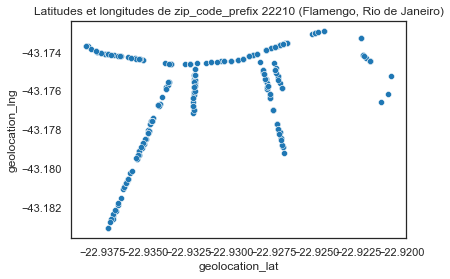

In [17]:
flamengo = geolocation[geolocation['geolocation_zip_code_prefix'] == 22210]
sns.scatterplot(data=flamengo, x='geolocation_lat', y='geolocation_lng')
plt.title(
    'Latitudes et longitudes de zip_code_prefix 22210 (Flamengo, Rio de Janeiro)')


#### Créer geolocations uniques des zipcodes

Les données sont anonymisées, donc on prend la médiane des (lat,lng) pour chaque zip code, après avoir éliminé les 42 registres avec coordonées hors bresil (la mèdiane doit éliminer l'effet de quelques erreurs de lat,lng pour chaque zipcode)


In [18]:
geoloc: pd.DataFrame = (geolocation
                        .drop(hors_bresil.index)
                        .dropna(subset=['geolocation_lat', 'geolocation_lng'])
                        .groupby(['geolocation_zip_code_prefix', 'geolocation_state'])
                        .agg({'geolocation_lat': 'median', 'geolocation_lng': 'median', 'geolocation_city': 'count'})
                        .rename(columns={'geolocation_city': 'count'})
                        .reset_index())
print(geoloc.shape)
decrire_dataframe(geoloc)


(19018, 5)
19018 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.00,19010,int64,1001,99990,30904.84
geolocation_state,0.00,27,object,AC,TO,nan
geolocation_lat,0.00,18993,float64,-33.69,4.48,7.24
geolocation_lng,0.00,18993,float64,-72.91,-34.80,5.20
count,0.00,483,int64,1,1146,72.06


Il y a 8 zipcodes avec duplicates :


In [19]:
geoloc_dups = geoloc[geoloc.duplicated(
    keep=False, subset=['geolocation_zip_code_prefix'])]
geoloc_dups.head(8)


,geolocation_zip_code_prefix,geolocation_state,geolocation_lat,geolocation_lng,count
367,2116,RN,-23.52,-46.58,1
368,2116,SP,-23.52,-46.58,12
1669,4011,AC,-23.58,-46.65,1
1670,4011,SP,-23.58,-46.64,178
6507,21550,AC,-22.86,-43.35,1
6508,21550,RJ,-22.86,-43.35,170
6698,23056,AC,-22.92,-43.61,1
6699,23056,RJ,-22.92,-43.61,60


Supprime les zipcodes duplicates ou il y a moins d'entrées


In [20]:
geoloc = geoloc.sort_values(by='count', ascending=False).drop_duplicates(
    keep='first', subset='geolocation_zip_code_prefix')
decrire_dataframe(geoloc)


19010 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.00,19010,int64,1001,99990,30903.69
geolocation_state,0.00,27,object,AC,TO,nan
geolocation_lat,0.00,18985,float64,-33.69,4.48,7.24
geolocation_lng,0.00,18985,float64,-72.91,-34.80,5.20
count,0.00,483,int64,1,1146,72.06


Text(0.5, 1.0, 'Localisation des zipcodes')

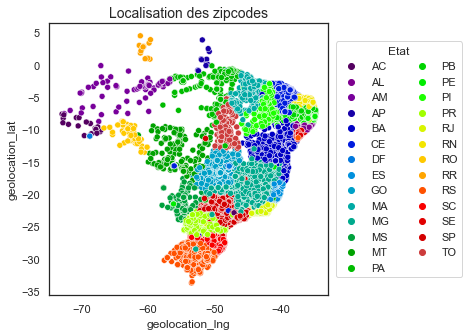

In [21]:
hue_order = sorted(geoloc['geolocation_state'].unique())
plt.figure(figsize=(5, 5))
sns.scatterplot(data=geoloc, x='geolocation_lng', y='geolocation_lat',
                hue='geolocation_state', hue_order=hue_order, palette='nipy_spectral')
plt.legend(title='Etat', bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)
plt.title('Localisation des zipcodes', fontsize=14)


Les zipcodes correspond à toutes les états féderals du Brésil. Quelques zipcodes sont attribuées au mauvais état ou au mauvais latitude, longitude.


### Order items


In [22]:
decrire_dataframe(order_items)


112650 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,98666,object,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,nan
order_item_id,0.00,21,int64,1,21,0.71
product_id,0.00,32951,object,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58,nan
seller_id,0.00,3095,object,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726,nan
shipping_limit_date,0.00,93318,object,2016-09-19 00:15:34,2020-04-09 22:35:08,nan
price,0.00,5968,float64,0.85,6735.00,183.63
freight_value,0.00,6999,float64,0.00,409.68,15.81


In [23]:
order_items.duplicated(subset=['order_id', 'order_item_id']).sum()


0

#### Qualité des données order items

- Aucun donnée manquantes
- pas de dupliquées
- prix entre 0.85 et 6735
- Données atomiques - lien entre client et vendeur


### Order payments


In [24]:
decrire_dataframe(order_payments)


103886 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,99440,object,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,nan
payment_sequential,0.00,29,int64,1,29,0.71
payment_type,0.00,5,object,boleto,voucher,nan
payment_installments,0.00,24,int64,0,24,2.69
payment_value,0.00,29077,float64,0.00,13664.08,217.49


In [25]:
# combien de payments de zero valeur
len(order_payments[order_payments['payment_value'] == 0])


9

In [26]:
order_payments.groupby('order_id').agg(
    {'payment_type': set}).astype(str).value_counts()


payment_type                 
{'credit_card'}                  74259
{'boleto'}                       19784
{'voucher', 'credit_card'}        2245
{'voucher'}                       1621
{'debit_card'}                    1527
{'not_defined'}                      3
{'credit_card', 'debit_card'}        1
dtype: int64

In [27]:
order_payments.groupby('payment_type').agg(
    {'payment_value': sum}).sort_values(by='payment_value', ascending=False)


,payment_value
payment_type,
credit_card,12542084.19
boleto,2869361.27
voucher,379436.87
debit_card,217989.79
not_defined,0.00


#### Qualité des données order payments

- aucune donnée manquante
- pas clair quand le payment a été effectué (si 8 installements, payé en 8 fois, un fois par mois?)
- besoin d'aggreger payment_value pour savoir si c'est égal au valeur d'achat


### Order reviews


In [28]:
decrire_dataframe(order_reviews)


99224 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
review_id,0.00,98410,object,0001239bc1de2e33cb583967c2ca4c67,fffefe7a48d22f7b32046421062219d1,nan
order_id,0.00,98673,object,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244,nan
review_score,0.00,5,int64,1,5,1.35
review_comment_title,88.34,4527,object,NaN,NaN,nan
review_comment_message,58.70,36159,object,NaN,NaN,nan
review_creation_date,0.00,636,object,2016-10-02 00:00:00,2018-08-31 00:00:00,nan
review_answer_timestamp,0.00,98248,object,2016-10-07 18:32:28,2018-10-29 12:27:35,nan


In [29]:
order_reviews.groupby('order_id').agg(
    {'review_id': 'count'}).astype(str).value_counts()


review_id
1            98126
2              543
3                4
dtype: int64

Text(0.5, 1.0, 'Distribution du score des revues')

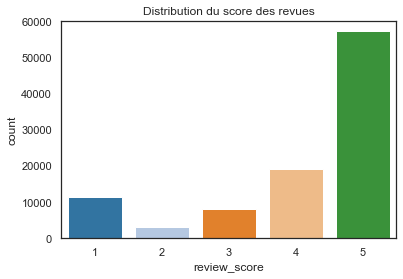

In [30]:
sns.countplot(data=order_reviews, x='review_score')
plt.title('Distribution du score des revues')


In [31]:
order_reviews[order_reviews['review_comment_title'].notnull()].head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho,2018-05-22 00:00:00,2018-05-23 16:45:47
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes do prazo.",2018-05-23 00:00:00,2018-05-24 03:00:01
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25
34,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4,Muito bom.,"Recebi exatamente o que esperava. As demais encomendas de outros vendedores atrasaram, mas esta chegou no prazo.",2018-06-07 00:00:00,2018-06-09 18:44:02


#### Qualité des données de 'review score':

- 98673 unique order_id (comparé avec 98666 unique order_id dans order_items)
- toutes les commandes on une score (aucune données manquantes dans colonne score)
- jusqu'à 3 revues par commande, mais moins de 0.5% des commandes ont plus d'un revue
- environ 40% des commandes contient un revue, seulement 11% contient un titre

Dans le perimetre de ce projet (segmentation des clients), on retient seulement le score pour chaque commande, et le nombre de reviews écrit.

- il peut être intéressant de faire du NLP sur les commentaires client, pour segmenter entre satisfait et pas satisfait, mais d'abord on voit si le score est suffisant.


### Orders (commandes)


In [32]:
decrire_dataframe(orders)


99441 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,99441,object,nan,nan,nan
customer_id,0.00,99441,object,nan,nan,nan
order_status,0.00,8,object,nan,nan,nan
order_purchase_timestamp,0.00,98875,object,nan,nan,nan
order_approved_at,0.16,90733,object,nan,nan,nan
order_delivered_carrier_date,1.79,81018,object,nan,nan,nan
order_delivered_customer_date,2.98,95664,object,nan,nan,nan
order_estimated_delivery_date,0.00,459,object,nan,nan,nan


In [33]:
orders['order_status'].value_counts()


delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [34]:
orders_sans_items = orders[~orders['order_id'].isin(order_items['order_id'])]
print(orders_sans_items.shape)
print(orders_sans_items['order_status'].value_counts())


(775, 8)
unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64


In [35]:
orders_sans_review = orders[~orders['order_id'].isin(
    order_reviews['order_id'])]
print(orders_sans_review.shape)
print(orders_sans_review['order_status'].value_counts())


(768, 8)
delivered      646
shipped         75
canceled        20
unavailable     14
processing       6
invoiced         5
created          2
Name: order_status, dtype: int64


In [36]:
orders[orders['order_status'] != 'delivered'].head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


In [37]:
decrire_dataframe(orders[orders['order_status'] == 'delivered'])


96478 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_id,0.00,96478,object,nan,nan,nan
customer_id,0.00,96478,object,nan,nan,nan
order_status,0.00,1,object,nan,nan,nan
order_purchase_timestamp,0.00,95956,object,nan,nan,nan
order_approved_at,0.01,88274,object,nan,nan,nan
order_delivered_carrier_date,0.00,80106,object,nan,nan,nan
order_delivered_customer_date,0.01,95658,object,nan,nan,nan
order_estimated_delivery_date,0.00,445,object,nan,nan,nan


#### Qualité de données des commandes

- autant de clients uniques que commandes uniques que registres (pas de dupliques)
- aucune données manquantes pour les commandes livrés
- pour les commandes pas livrés, les données manquantes sont expliqués par le non-livraison

- les produits non-livrés seront plus complexe à analyser, car beaucoup non pas d'items associés (aucun idée de ceux que le client a commandé), et beaucoup non pas des reviews associés (aucun idée de la satisfaction de la client)


### Products (et product category names)


In [38]:
decrire_dataframe(products)


32951 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
product_id,0.00,32951,object,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58,nan
product_category_name,1.85,73,object,NaN,NaN,nan
product_name_lenght,1.85,66,float64,5.00,76.00,10.25
product_description_lenght,1.85,2960,float64,4.00,3992.00,635.12
product_photos_qty,1.85,19,float64,1.00,20.00,1.74
product_weight_g,0.01,2204,float64,0.00,40425.00,4282.04
product_length_cm,0.01,99,float64,7.00,105.00,16.91
product_height_cm,0.01,102,float64,2.00,105.00,13.64
product_width_cm,0.01,95,float64,6.00,118.00,12.08


In [39]:
products[products['product_category_name'].isna()].head()


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,nan,nan,nan,650.00,17.00,14.00,12.00
128,d8dee61c2034d6d075997acef1870e9b,NaN,nan,nan,nan,300.00,16.00,7.00,20.00
145,56139431d72cd51f19eb9f7dae4d1617,NaN,nan,nan,nan,200.00,20.00,20.00,20.00
154,46b48281eb6d663ced748f324108c733,NaN,nan,nan,nan,18500.00,41.00,30.00,41.00
197,5fb61f482620cb672f5e586bb132eae9,NaN,nan,nan,nan,300.00,35.00,7.00,12.00


In [40]:
products['product_category_name'].value_counts(
    normalize=True).cumsum().head()*100


cama_mesa_banho          9.37
esporte_lazer           18.23
moveis_decoracao        26.45
beleza_saude            34.00
utilidades_domesticas   41.22
Name: product_category_name, dtype: float64

In [41]:
products['product_category_name'].value_counts(normalize=True).tail()*100


casa_conforto_2                 0.02
fashion_roupa_infanto_juvenil   0.02
pc_gamer                        0.01
seguros_e_servicos              0.01
cds_dvds_musicais               0.00
Name: product_category_name, dtype: float64

#### Qualité des données 'products'

- 2% des produits n'ont pas de catégorie ni description
- 73 catégories differents, 5 catégories contient 40% des produits
- peut-être vaut le coup de cluster les catégories des produits?
- besoin de traduire les catégories de portugues en anglais, par exemple.
- plus de traitement aprés élimination des produits non-vendus


### Sellers


In [42]:
decrire_dataframe(sellers)


3095 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
seller_id,0.00,3095,object,0015a82c2db000af6aaaf3ae2ecb0532,ffff564a4f9085cd26170f4732393726,nan
seller_zip_code_prefix,0.00,2246,int64,1001,99730,32713.45
seller_city,0.00,611,object,04482255,xaxim,nan
seller_state,0.00,23,object,AC,SP,nan


#### Qualité de données 'sellers'

- aucune données manquantes
- la ville n'est pas toujours une vraie ville
- environ un vendeur pour chaque 33 commandes (3095 vendeurs, 99000 commandes)
- besoin de merge avec geolocation pour savoir la localisation du vendeur


## 2.4 Nettoyage des données

Le but est de pouvoir aggréger plusieurs indicateurs / kpi sur chaque `customer_unique_id`

On commence par rassembler les données de plusieurs tables

- customers_geo = customers + geolocation
- sellers_geo = sellers + geolocation
- products_en = products + product_category_names


### Geolocation des clients


In [43]:
geolocal = geoloc[['geolocation_zip_code_prefix',
                   'geolocation_lng', 'geolocation_lat']]
geolocal.columns = ['customer_zip_code_prefix', 'customer_lng', 'customer_lat']
customers_geo = customers.merge(
    geolocal, on='customer_zip_code_prefix', how='left')
customers_geo['customer_id'] = customers_geo['customer_id'].astype('object')
customers_geo.isna().sum()


customer_id                   0
customer_unique_id            0
customer_zip_code_prefix      0
customer_city                 0
customer_state                0
customer_lng                279
customer_lat                279
dtype: int64

quelques 'customer_zip_code_prefix' ne sont pas dans geolocalisation


In [44]:
sans_geo = customers_geo[customers_geo['customer_lat'].isnull()]
sans_geo[['customer_state', 'customer_city',
          'customer_zip_code_prefix']].value_counts().head()


customer_state  customer_city  customer_zip_code_prefix
DF              brasilia       70686                       15
                               72005                       13
                               71919                       10
                               73255                        7
                               72300                        6
dtype: int64

#### Imputation des latitudes et longitudes manquantes à partir des zip_code_prefix

Les clients avec zipcode similaire auront geolocalisation similaire


In [45]:
from sklearn.impute import KNNImputer
impute_cols = ['customer_zip_code_prefix', 'customer_lng', 'customer_lat']
imputer = KNNImputer(n_neighbors=5)
customers_geo[impute_cols] = imputer.fit_transform(customers_geo[impute_cols])
customers_geo.isna().mean()


customer_id                0.00
customer_unique_id         0.00
customer_zip_code_prefix   0.00
customer_city              0.00
customer_state             0.00
customer_lng               0.00
customer_lat               0.00
dtype: float64

Text(0.5, 1.0, 'Localisation des clients - Distrito Federal')

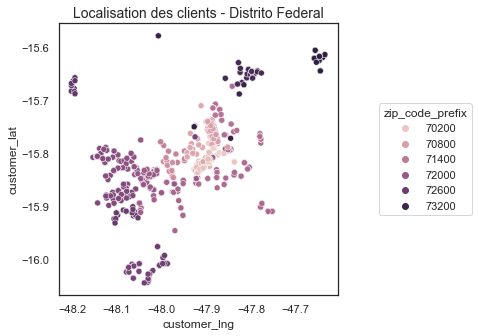

In [46]:
DF = customers_geo[customers_geo['customer_state'] == 'DF']
plt.figure(figsize=(5, 5))
sns.scatterplot(data=DF, x='customer_lng', y='customer_lat',
                hue='customer_zip_code_prefix')
plt.legend(title='zip_code_prefix', bbox_to_anchor=(1.5, 0.5), loc=5)
plt.title('Localisation des clients - Distrito Federal', fontsize=14)


In [47]:
def add_text(ax, x, y, s, **kwargs):
    """Ajouter du texte à un plot"""
    ax.text(x, y, s, verticalalignment='bottom',
            horizontalalignment='left', transform=ax.transAxes, **kwargs)


Text(0.5, 1.0, 'Localisation des clients')

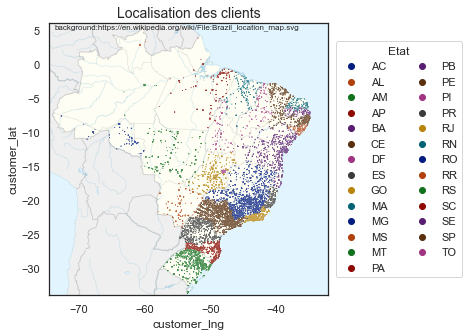

In [48]:
states_order = sorted(list(customers_geo['customer_state'].unique()))
plt.figure(figsize=(5, 5))
img_src = 'https://en.wikipedia.org/wiki/File:Brazil_location_map.svg'
img = plt.imread('Brazil_location_map.svg.png')
ax = sns.scatterplot(data=customers_geo, x='customer_lng', y='customer_lat',
                     hue='customer_state', hue_order=states_order, s=1, palette='dark')
# plt.xlim(-74.5, -32)
# plt.ylim(-34, 6)
ax.imshow(img, extent=[-74.5, -32, -34, 6], aspect='auto', alpha=0.5)
add_text(ax, 0.02, 0.97, s=f'background:{img_src}', fontsize=8)
plt.legend(title='Etat', bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)
plt.title('Localisation des clients', fontsize=14)


On remarque que les clients sont distribués partout le pays de brésil


### Geolocation des vendeurs


In [49]:
print(sellers[['seller_state']].value_counts().head())
geolocal.columns = ['seller_zip_code_prefix', 'seller_lng', 'seller_lat']
sellers_geo = sellers.merge(geolocal, on='seller_zip_code_prefix', how='left')
sellers_sans_geo = sellers_geo['seller_lng'].isna().sum()
print(f'sellers sans geolocalisation : {sellers_sans_geo}')


seller_state
SP              1849
PR               349
MG               244
SC               190
RJ               171
dtype: int64
sellers sans geolocalisation : 7


In [50]:
from sklearn.impute import KNNImputer
impute_cols = ['seller_zip_code_prefix', 'seller_lng', 'seller_lat']
imputer = KNNImputer(n_neighbors=5)
sellers_geo[impute_cols] = imputer.fit_transform(sellers_geo[impute_cols])
# sellers_geo.isna().mean()


Text(0.5, 1.0, 'Localisation des vendeurs')

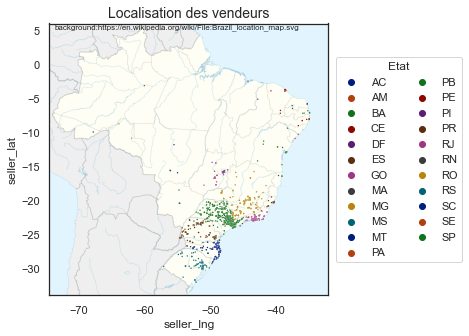

In [51]:

states_order = sorted(list(sellers_geo['seller_state'].unique()))
plt.figure(figsize=(5, 5))
ax = sns.scatterplot(data=sellers_geo, x='seller_lng', y='seller_lat',
                     hue='seller_state', hue_order=states_order, s=2, palette='dark')
ax.imshow(img, extent=[-74.5, -32, -34, 6], aspect='auto', alpha=0.5)
add_text(ax, 0.02, 0.97, s=f'background:{img_src}', fontsize=8)
plt.legend(title='Etat', bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)
plt.title('Localisation des vendeurs', fontsize=14)


Les vendeurs sont concentrés dans les états du sud du brésil (Sao Paulo, Parana, Minas Gerais, Santa Catarina, Rio de Janeiro)


### Catégories des produits en anglais


In [52]:
products_en = (products
               .merge(product_category_names, on='product_category_name', how='left')
               .drop(columns=[])
               )
products_en.isna().sum().sort_values(ascending=False)


product_category_name_english    623
product_photos_qty               610
product_description_lenght       610
product_name_lenght              610
product_category_name            610
product_width_cm                   2
product_height_cm                  2
product_length_cm                  2
product_weight_g                   2
product_id                         0
dtype: int64

On traite plus tard les valeurs manquantes seulement pour les produits commandés.


### Nettoyage de la table 'orders' (commandes qui ne sont pas livrés)

Pour segmentation des clients, on veut analyser seulement les commandes livrés, car ce qui ne sont pas livrés n'auront pas des reviews, et beaucoup des commandes non-livrés n'a pas d'items (on ne sait pas ceux qui le client a acheté)


In [53]:
pd.crosstab(orders['order_status'],
            orders['order_delivered_customer_date'].notnull())


order_delivered_customer_date,False,True
order_status,,
approved,2,0
canceled,619,6
created,5,0
delivered,8,96470
invoiced,314,0
processing,301,0
shipped,1107,0
unavailable,609,0


In [54]:
order_scores = pd.merge(orders, order_reviews, on='order_id', how='inner')

order_scores.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,e73b67b67587f7644d5bd1a52deb1b01,5,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,359d03e676b3c069f62cadba8dd3f6e8,5,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,e50934924e227544ba8246aeb3770dd4,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


In [55]:
scores = pd.crosstab(order_scores['order_status'],
                     order_scores['review_score'])
scores


review_score,1,2,3,4,5
order_status,,,,,
approved,1,0,0,1,0
canceled,422,44,48,26,69
created,2,0,0,0,1
delivered,9406,2941,7961,18987,57066
invoiced,230,26,16,15,26
processing,256,18,9,6,7
shipped,644,79,110,87,123
unavailable,463,43,35,20,36


Text(0.5, 0.98, 'Distribution de scores ')

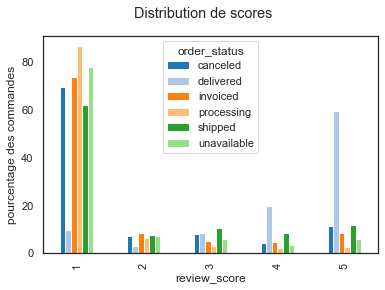

In [56]:
scores.drop(['approved', 'created']).apply(lambda row: 100*row /
                                           row.sum(), axis=1).T.plot(kind='bar', stacked=False)
plt.ylabel('pourcentage des commandes')
plt.suptitle('Distribution de scores ')


Text(0.5, 1.0, 'Review score en fonction du status de la commande')

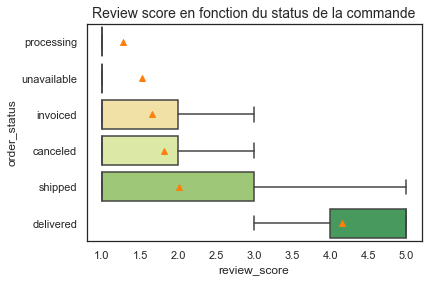

In [57]:
# ignore categories avec 5 ou moins registres
order_scores = order_scores[~order_scores['order_status'].isin(
    ['created', 'approved'])]
box_order = order_scores.groupby('order_status')[
    'review_score'].agg('mean').sort_values().index
sns.boxplot(data=order_scores, x='review_score', y='order_status', order=box_order,
            showmeans=True, showfliers=False, palette=sns.color_palette('RdYlGn'))
plt.title('Review score en fonction du status de la commande', fontsize=14)


Tant que les produits ne sont pas livrés, les review_score sont bas

Il se peut que les clients qui annulent leur commande, ou qui restent en attent de livraison donnera un note plus bas jusqu'à ce que la commande arrive

#### Supprime les commandes pas encore livrés

- Si on segment sur les commandes pas livrés, on ne peut pas être sur que c'est representative, car les scores se modifie après livraison.


In [58]:
orders_delivered = orders[(orders['order_status'] == 'delivered') &
                          (orders['order_delivered_customer_date'].notnull())]
print(orders_delivered.shape)


(96470, 8)


### Aggréger order_review par order_id

On utilisera seulement le score moyenne par commande.

Le perimetre de ce projet ne donne pas le temps pour analyser les texts des commentaires, qui peuvent nuancer les segments des clients.

La présence des commentaires/titres peut être util pour distinguer les clients

- Les clients qui laisse une commentaire sont peut-être plus engagé que ceux qui ont un simple note
- Ceux qui donne une titre au revue, encore plus ?
- on remplit les valeurs manquantes pour message et title avec '' pour concatener les commentaires


In [59]:
for col in ['review_comment_message', 'review_comment_title']:
    order_reviews[col] = order_reviews[col].fillna('')

order_reviews['review_nb_comments'] = (
    order_reviews['review_comment_message'] != '').astype(float)
order_reviews['review_nb_title'] = (
    order_reviews['review_comment_title'] != '').astype(float)


def agg_join(x): return '; '.join(x)


order_reviews_agg = order_reviews.groupby('order_id').agg({
    'review_score': 'mean',
    'review_nb_comments': 'sum',
    'review_nb_title': 'sum',
    'review_comment_message': agg_join,
    'review_comment_title': agg_join,
}).reset_index()

order_reviews_agg.sort_values(by='review_nb_title', ascending=False).head()


,order_id,review_score,review_nb_comments,review_nb_title,review_comment_message,review_comment_title
43650,7144ca093cbdecfdfc3e76d49da6ffb9,2.50,2.00,2.00,Está faltando receber um produto: Pulseira Masculina de Couro Caveira Couro Legítimo + Pedra Preto 20 ; Recebi o produto errado.,Sem recomendação; Recomendo
50980,84aa61a900410cfe26b57337d376a1ae,5.00,2.00,2.00,Recomendo!; Recomendo!,Ótima; Ótima
43683,715b8576b74d53796bcbb107a201eb55,5.00,2.00,2.00,"Produto lindo,adorei!!; Fiquei muito satisfeita com o produto,fiz um pedido especial para entrega ,e eles acolheram este pedido,que pra mim fez toda a diferença.Muito feliz obrigada nota 10.",super recomendo; super recomendo
2040,0544030711e50ec2cb6c15764d22891a,2.50,1.00,2.00,"; Comprei duas válvulas solenóides iguais. Paguei o mesmo produto com quantidade 2 (dois). As válvulas são iguais, mas as roscas são diferentes. Uma é BSP, com passo igual a NPT, a outra tem passo maio",Não quero avaliar; É muito confusa.
74718,c1deab56eafcb4bec7703bbe7bd25137,3.00,2.00,2.00,produto fora da minha expectativa ; recomendo a loja,produto horrivel; bom


### Aggréger order_payments par order_id

Pour eviter de créer plusieurs lignes sur join, il faut seulement un ligne par commande dans order_payments.

Les indicateurs d'interesse sont:

- payment_type
- payment_value
- payment_installments


In [60]:
order_payment_dups = (order_payments[order_payments.duplicated(subset=['order_id'], keep=False)]
                      .sort_values(by='order_id'))
print(order_payment_dups.shape)
order_payment_dups.head(2)


(7407, 5)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63


On peut considerer :

- que les 'voucher' sont payés immediatement (installment=0); donc
- payment_installments = max(payment_installments) pour chaque commande

Pour pouvoir fusionner avec les autres tables, on réduit cette table à un ligne par commande (création d'une nouvelle 'order_payments_agg'):


In [61]:
order_payments_piv = (pd.pivot_table(order_payments, index=['order_id'],
                                     columns='payment_type', values='payment_value', fill_value=0,
                                     aggfunc='sum', margins='row', margins_name="payment_value")
                      .reset_index().set_index('order_id').drop('payment_value', axis=0))
print(order_payments_piv.shape)


def agg_set(x): return ', '.join(sorted(list(set(x))))


order_method = (order_payments.groupby('order_id').agg(
    {'payment_installments': max, 'payment_type': agg_set}))
order_method['payment_type'] = order_method['payment_type'].astype(str)
print(order_method.shape)

order_payments_agg = pd.merge(
    order_method, order_payments_piv, on='order_id', how='inner')
order_payments_agg[order_payments_agg['voucher'] > 0].tail()


(99440, 6)
(99440, 2)


,payment_installments,payment_type,boleto,credit_card,debit_card,not_defined,voucher,payment_value
order_id,,,,,,,,
ff20ee702706d9e407a34de9fe2ff768,6,"credit_card, voucher",0.00,132.10,0.00,0,50.00,182.10
ff7400d904161b62b6e830b3988f5cbd,1,"credit_card, voucher",0.00,54.96,0.00,0,100.00,154.96
ff978de32e717acd3b5abe1fb069d2b6,1,voucher,0.00,0.00,0.00,0,49.14,49.14
ffa1dd97810de91a03abd7bd76d2fed1,1,"credit_card, voucher",0.00,36.58,0.00,0,418.73,455.31
ffa39020fe7c8a3e907320e1bec4b985,1,"credit_card, voucher",0.00,7.13,0.00,0,64.01,71.14


In [62]:
order_payments_agg['payment_type'].value_counts()


credit_card                74259
boleto                     19784
credit_card, voucher        2245
voucher                     1621
debit_card                  1527
not_defined                    3
credit_card, debit_card        1
Name: payment_type, dtype: int64

In [63]:
decrire_dataframe(order_payments_agg)


99440 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
payment_installments,0.00,24,int64,0,24,2.72
payment_type,0.00,7,object,boleto,voucher,nan
boleto,0.00,10542,float64,0.00,7274.88,111.48
credit_card,0.00,25430,float64,0.00,13664.08,207.84
debit_card,0.00,1382,float64,0.00,4445.50,35.16
not_defined,0.00,1,int64,0,0,0.00
voucher,0.00,2846,float64,0.00,3184.34,34.11
payment_value,0.00,28029,float64,0.00,13664.08,221.95


### Convertir zip_codes en object

Maintenant que les latitudes et longitudes sont remplis, on peut convertir zip_code en object


In [64]:
customers_geo['customer_zip_code_prefix'] = customers_geo['customer_zip_code_prefix'].astype(
    object)
sellers_geo['seller_zip_code_prefix'] = sellers_geo['seller_zip_code_prefix'].astype(
    object)


## 2.5 Fusionne des tables

On peut créer des indicateurs individuellement, par des joins necessaire pour chaque indicateur. Pourtant, il sera dificile de verifier que les indicateurs font référence aux mêmes clients.

Avec la quantité de données present, on peut fusionner (merge) les données de toutes les tables, pour ensuite pouvoir génerer les indicateurs nécessaire pour segmentation.

Les nouvelles tables sont:

- **commandes** - pour pouvoir aggréger order dates, payment types, reviews par unique customer_id
- **commande_items** - pour aggréger catégories de produit, sellers, distances par unique customer_id
- **clients** - accumulation des indicateurs par unique_customer_id, pour faire la segmentation des clients


### Création de la table 'commandes'

La fusion d'information sur les commandes (sans detailles des items de chaque commande) permet de faire un analyse RFM (Recency Frequency MonetaryValue), par exemple.


In [65]:
print(f'customers_geo.shape : {customers_geo.shape}')
print(f'orders_delivered.shape : {orders_delivered.shape}')
print(f'order_reviews_agg.shape : {order_reviews_agg.shape}')
print(f'order_payments_agg.shape : {order_payments_agg.shape}')
commandes = (orders_delivered
             .merge(order_reviews_agg, on='order_id', how='inner')
             .merge(order_payments_agg, on='order_id', how='left')
             .merge(customers_geo, on='customer_id', how='left')
             )

print(f'commandes.shape : {commandes.shape}')
decrire_dataframe(commandes).sort_values(by='% manquantes', ascending=False)


customers_geo.shape : (99441, 7)
orders_delivered.shape : (96470, 8)
order_reviews_agg.shape : (98673, 6)
order_payments_agg.shape : (99440, 8)
commandes.shape : (95824, 27)
95824 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
order_approved_at,0.01,87719,object,NaN,NaN,nan
payment_installments,0.00,24,float64,0.00,24.00,2.71
boleto,0.00,10242,float64,0.00,7274.88,108.93
order_delivered_carrier_date,0.00,79604,object,NaN,NaN,nan
payment_value,0.00,27403,float64,9.59,13664.08,217.51
...,...,...,...,...,...,...
order_estimated_delivery_date,0.00,445,object,2016-10-04 00:00:00,2018-10-25 00:00:00,nan
order_delivered_customer_date,0.00,95016,object,2016-10-11 13:46:32,2018-10-17 13:22:46,nan
order_purchase_timestamp,0.00,95309,object,2016-09-15 12:16:38,2018-08-29 15:00:37,nan


#### Commandes - traitement des données manquantes

La plupart des données manquantes sont pour les commandes pas livrés


In [66]:
rows_missing_data = commandes[commandes.isna().any(axis=1)]
print(len(rows_missing_data))
rows_missing_data.head()


16


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_nb_comments,review_nb_title,review_comment_message,review_comment_title,payment_installments,payment_type,boleto,credit_card,debit_card,not_defined,voucher,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lng,customer_lat
5140,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00,4.00,1.00,0.00,"Muita demora, mas, tudo ok.\r\nTerezinha",,1.00,boleto,349.01,0.00,0.00,0.00,0.00,349.01,8a9a08c7ca8900a200d83cf838a07e0b,6708.00,cotia,SP,-46.85,-23.59
16014,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00,5.00,0.00,0.00,,,1.00,boleto,396.86,0.00,0.00,0.00,0.00,396.86,91efb7fcabc17925099dced52435837f,93548.00,novo hamburgo,RS,-51.12,-29.69
18390,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00,5.00,0.00,0.00,,,1.00,boleto,65.52,0.00,0.00,0.00,0.00,65.52,e1f01a1bd6485e58ad3c769a5427d8a8,8230.00,sao paulo,SP,-46.45,-23.52
21869,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00,5.00,0.00,0.00,,,1.00,boleto,106.81,0.00,0.00,0.00,0.00,106.81,7e1a5ca61b572d76b64b6688b9f96473,62700.00,caninde,CE,-39.31,-4.36
22345,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00,5.00,0.00,0.00,,,1.00,boleto,95.76,0.00,0.00,0.00,0.00,95.76,c8822fce1d0bfa7ddf0da24fff947172,27945.00,macae,RJ,-41.80,-22.37


#### Supprime les 16 registres avec données manquantes


In [67]:
commandes = commandes.dropna()


#### Convertir les colonnes datetime


In [68]:
date_cols = ['order_purchase_timestamp',
             'order_approved_at', 'order_delivered_carrier_date',
             'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_cols:
    commandes[col] = pd.to_datetime(commandes[col], errors='coerce')

commandes.select_dtypes(exclude='number').info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 95808 entries, 0 to 95823
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       95808 non-null  object        
 1   customer_id                    95808 non-null  object        
 2   order_status                   95808 non-null  object        
 3   order_purchase_timestamp       95808 non-null  datetime64[ns]
 4   order_approved_at              95808 non-null  datetime64[ns]
 5   order_delivered_carrier_date   95808 non-null  datetime64[ns]
 6   order_delivered_customer_date  95808 non-null  datetime64[ns]
 7   order_estimated_delivery_date  95808 non-null  datetime64[ns]
 8   review_comment_message         95808 non-null  object        
 9   review_comment_title           95808 non-null  object        
 10  payment_type                   95808 non-null  object        
 11  customer_unique

### Création de la table 'commande*items' (\_items commandés*)

On fusionne la table des commandes avec les items (le niveau plus atomique), à fin de pouvoir analyser, par exemple, pour chaque client:

- les type de produits achétés
- la distance entre vendeur et acheteur
- la taille / poids des achats
- l'influence de photos sur les achats


In [69]:
print(f'commandes.shape : {commandes.shape}')
print(f'order_items.shape : {order_items.shape}')
commande_items = commandes.merge(order_items, on='order_id', how='left')
print(
    f'commande_items.shape (après merge order_items) : {commande_items.shape}')

commande_items = commande_items.merge(sellers_geo, on='seller_id', how='left')
print(f'commande_items.shape (après merge sellers) : {commande_items.shape}')

commande_items = commande_items.merge(products_en, on='product_id', how='left')
print(f'commande_items.shape (après merge products) : {commande_items.shape}')

decrire_dataframe(commande_items).sort_values(
    by='% manquantes', ascending=False)


commandes.shape : (95808, 27)
order_items.shape : (112650, 7)
commande_items.shape (après merge order_items) : (109343, 33)
commande_items.shape (après merge sellers) : (109343, 38)
commande_items.shape (après merge products) : (109343, 47)
109343 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
product_category_name_english,1.41,71,object,NaN,NaN,nan
product_photos_qty,1.39,19,float64,1.00,20.00,1.72
product_description_lenght,1.39,2942,float64,4.00,3992.00,651.17
product_name_lenght,1.39,65,float64,5.00,76.00,10.01
product_category_name,1.39,73,object,NaN,NaN,nan
...,...,...,...,...,...,...
not_defined,0.00,1,float64,0.00,0.00,0.00
voucher,0.00,2696,float64,0.00,1839.05,28.91
payment_value,0.00,27400,float64,9.59,13664.08,269.45


### Items commandés - traitement des données manquantes


In [70]:
missing = commande_items.columns[commande_items.isnull().any()]
commande_items[missing].isna().sum()


product_category_name            1524
product_name_lenght              1524
product_description_lenght       1524
product_photos_qty               1524
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
product_category_name_english    1546
dtype: int64

#### Remplir valeurs manquantes


In [71]:
for col in ['product_category_name', 'product_category_name_english']:
    commande_items[col] = commande_items[col].fillna('missing')

commande_items = commande_items.fillna(0)


#### Convertir colonnes en datetime


In [72]:
item_date_cols = ['shipping_limit_date']
for col in item_date_cols:
    commande_items[col] = pd.to_datetime(commande_items[col], errors='coerce')


In [73]:
missing = commande_items.columns[commande_items.isnull().any()]
commande_items[missing].isna().sum()


Series([], dtype: float64)

### Création de la table 'clients' (RFM et autres indicateurs client)

La table **clients** accumule les indicateurs par unique_customer_id, pour faire la segmentation des clients

On commence par créer les indicateurs RFM


#### Indicateurs RFM

- Recency = date de la dernière achat (relative à la date à laquelle ce jeu de données a été enregistré)
- Frequency = fréquence des achats
- MonetaryValue = moyenne valeur des achats


In [74]:
last_date = commandes['order_delivered_customer_date'].max()
last_date_carrier = commandes['order_delivered_carrier_date'].max()
last_date_purchase = commandes['order_purchase_timestamp'].max()
print(last_date)
print(last_date_carrier)
print(last_date_purchase)


2018-10-17 13:22:46
2018-09-11 19:48:28
2018-08-29 15:00:37


In [75]:
clients = commandes.groupby("customer_unique_id").agg({
    'order_purchase_timestamp': 'max',
    'customer_id': 'count',
    'payment_value': 'mean'
})

clients.columns = ['dernier_achat', 'Frequency', 'MonetaryValue']
clients['Recency'] = (clients['dernier_achat'] - last_date).dt.days
clients.sort_values(by='Frequency', ascending=False).head()


,dernier_achat,Frequency,MonetaryValue,Recency
customer_unique_id,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-20 19:14:26,15,58.62,-58
3e43e6105506432c953e165fb2acf44c,2018-02-27 18:36:39,9,130.30,-232
ca77025e7201e3b30c44b472ff346268,2018-06-01 11:38:29,7,160.39,-139
1b6c7548a2a1f9037c1fd3ddfed95f33,2018-02-14 13:22:12,7,137.00,-246
6469f99c1f9dfae7733b25662e7f1782,2018-06-28 00:43:34,7,108.40,-112


# 3. Analyse Exploratoire


## 3.1 Données numériques


## 3.2 Données catégoriques


## 3.3 Associations entre variables catégoriques et numériques


# 4. Feature Engineering


## 4.1 Nouvelles 'features' catégoriques


## 4.2 Nouvelles 'features' numériques


## 4.3 Pipeline de Feature Engineering


# 5. Enregistrement des données nettoyées


## 5.1 Sommaire des données nettoyées
